# Mobilenet Transfer Learning on MRI Imagery for Alzheimers Classification


## Importing Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchsummary import summary
import torchvision
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score
from tqdm import tqdm

import os

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Importing the Dataset

In [ ]:
# Dataset paths

"""

In order to load the datasets from the shared folder, go to google drive, right click the shared folder, and create a shortcut
to somewhere in your drive.

"""

# Ben's dataset paths
ben_train_dataset_path = "/content/gdrive/MyDrive/24S Classes/Deep Learning/COSC78 Final Project/Train Data"
ben_validation_dataset_path = "/content/gdrive/MyDrive/24S Classes/Deep Learning/COSC78 Final Project/Validation Data"
ben_test_dataset_path = "/content/gdrive/MyDrive/24S Classes/Deep Learning/COSC78 Final Project/Test Data"

# Dawson's dataset paths
daw_train_dataset_path = '/content/gdrive/MyDrive/COSC78 Final Project/Train Data'
daw_validation_dataset_path = '/content/gdrive/MyDrive/COSC78 Final Project/Validation Data'
daw_test_dataset_path = '/content/gdrive/MyDrive/COSC78 Final Project/Test Data'

# Will's dataset paths
will_train_dataset_path = '/content/gdrive/MyDrive/COSC78/COSC78 Final Project/Train Data'
will_validation_dataset_path = '/content/gdrive/MyDrive/COSC78/COSC78 Final Project/Validation Data'
will_test_dataset_path = '/content/gdrive/MyDrive/COSC78/COSC78 Final Project/Test Data'

# Brian's dataset paths
bri_train_dataset_path = '/content/gdrive/MyDrive/Algorithms - Collab/CS 78/COSC78 Final Project/Train Data'
bri_val_dataset_path = '/content/gdrive/MyDrive/Algorithms - Collab/CS 78/COSC78 Final Project/Validation Data'
bri_test_dataset_path = '/content/gdrive/MyDrive/Algorithms - Collab/CS 78/COSC78 Final Project/Test Data'

In [ ]:
# Crops an image
left_crop = 15
right_crop = 75
def custom_crop(img):
  width, height = img.size
  return img.crop((left_crop, 0, width - right_crop, height))

In [ ]:
'TODO: Define transformations - crop or resize'
transform = transforms.Compose([
    transforms.Lambda(custom_crop),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained models
])


# Adjust these depending on who is running the colab
curr_train_dataset_path = will_train_dataset_path
curr_validation_dataset_path = will_validation_dataset_path
curr_test_dataset_path = will_test_dataset_path

# Setup datasets using ImageFolder
train_dataset = datasets.ImageFolder(curr_train_dataset_path, transform=transform)
val_dataset = datasets.ImageFolder(curr_validation_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(curr_test_dataset_path, transform=transform)

# Classes: {'Mild Dementia Subset': 0, 'Non Demented Subset': 1, 'Very mild Dementia Subset': 2}
# added imports os & WeightedRandomSampler at top
class_index = train_dataset.class_to_idx

train_counts = [0, 0, 0]
for output_class in class_index.keys():
  train_samples = os.listdir(curr_train_dataset_path + '/' + output_class)
  train_counts[class_index[output_class]] = len(train_samples)

train_total = sum(train_counts)
class_weights = torch.tensor([train_total / x for x in train_counts])
class_weights /= torch.sum(class_weights)

sample_weights = torch.tensor([class_weights[train_dataset.targets[i]] for i in range(len(train_dataset))]).to(torch.device("cpu"))

print(sample_weights)
random_oversampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
print(random_oversampler)


# Create dataloaders

# loader WITH oversampling:
train_loader = DataLoader(train_dataset, batch_size=256, sampler=random_oversampler)
# loader WITHOUT oversampling
# train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


tensor([0.7016, 0.7016, 0.7016,  ..., 0.2483, 0.2483, 0.2483])


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import and modify the model

In [ ]:
# Load the pre-trained MobileNetV3 model
pretrained_weights = torchvision.models.MobileNet_V3_Small_Weights
mobilenet_model = torchvision.models.mobilenet_v3_small(weights=pretrained_weights)

# Freeze all the parameters for fine-tuning
for param in mobilenet_model.parameters():
    param.requires_grad = False

# Replace the classifier layer
mobilenet_model.classifier[3] = nn.Linear(mobilenet_model.classifier[3].in_features, 3)
mobilenet_model.classifier.requires_grad_ = True

summary(mobilenet_model, input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 73.9MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

## Fine tune the model

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters())
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Decreases the learning rate by a factor of 0.1 every 10 epochs
torch.manual_seed(24)

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, scheduler, loss_func, epochs=25, patience=10, save_path='best_model.pth'):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
    model.to(device)

    # To store the training and validation loss for plotting or analysis
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_f1': [], 'val_f1': []}

    best_val_loss = float('inf')
    patience_counter = 0  # Counter for the early stopping

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        train_preds, train_targets = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_accuracy = 100 * correct_train / total_train
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        epoch_train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f1'].append(train_f1)

        # Scheduler step (commonly after training step, can be adjusted as per scheduler type)
        scheduler.step()

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_func(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_accuracy = 100 * correct_val / total_val
        val_f1 = f1_score(val_targets, val_preds, average='weighted')
        epoch_val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_f1)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1: {val_f1:.4f}')

        # Check for improvement in validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Stopping early after {epoch + 1} epochs due to no improvement in validation loss.")
                model.load_state_dict(torch.load(save_path))  # Load the best model weights
                break

    return history

In [ ]:
history = train_and_validate(mobilenet_model, train_loader, val_loader, optimizer, scheduler, loss_func, epochs=3)

Epoch 1/3 - Validation: 100%|██████████| 21/21 [33:19<00:00, 95.22s/it]


Epoch [1/3], Train Loss: 0.7905, Train Accuracy: 66.73%, Train F1: 0.6670, Validation Loss: 0.6351, Validation Accuracy: 75.90%, Validation F1: 0.7014


Epoch 2/3 - Validation: 100%|██████████| 21/21 [02:28<00:00,  7.06s/it]


Epoch [2/3], Train Loss: 0.6269, Train Accuracy: 75.38%, Train F1: 0.7533, Validation Loss: 0.6644, Validation Accuracy: 76.07%, Validation F1: 0.7106


Epoch 3/3 - Validation: 100%|██████████| 21/21 [02:28<00:00,  7.09s/it]

Epoch [3/3], Train Loss: 0.5669, Train Accuracy: 78.08%, Train F1: 0.7801, Validation Loss: 0.6698, Validation Accuracy: 73.87%, Validation F1: 0.7105


In [ ]:
# Get test accuracy and scores
test_loss = 0
correct_test = 0
total_test = 0
test_preds, test_targets = [], []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for images, labels in tqdm(test_loader, desc=f"Test dataset"):
  images, labels = images.to(device), labels.to(device)
  optimizer.zero_grad()
  outputs = mobilenet_model(images)
  loss = loss_func(outputs, labels)

  test_loss += loss.item() * images.size(0)
  _, predicted = torch.max(outputs.data, 1)
  correct_test += (predicted == labels).sum().item()
  total_test += labels.size(0)

  test_preds.extend(predicted.cpu().numpy())
  test_targets.extend(labels.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
test_f1 = f1_score(test_targets, test_preds, average='weighted')
test_loss = test_loss / len(test_loader.dataset)

print(f"Test accuracy: {test_accuracy:.2f}%, Test f1 score: {test_f1:.4f}, Test loss: {test_loss:.4f}")



Test dataset: 100%|██████████| 42/42 [28:51<00:00, 41.23s/it]

Test accuracy: 72.47%, Test f1 score: 0.7053, Test loss: 0.6577


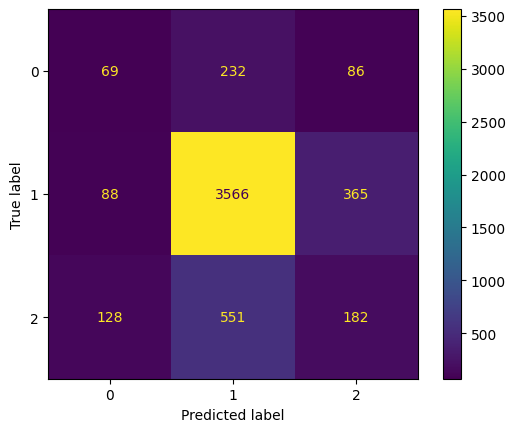

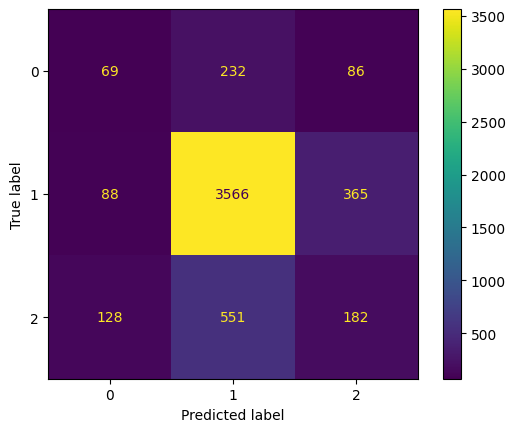

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_predictions(test_targets, test_preds)
cm.plot()